In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

In [2]:
def todate(x):
    s = str(x)
    return s[:4] + "-" + s[-2:]

In [3]:
df_1 = pd.read_csv('../data/data_4__.csv')
df_1['Date'] = df_1['YearMonth'].apply(lambda x: todate(x))
col = ['Srore_id','Product id','YearMonth']
df_1 = df_1.drop(col,axis=1)
df_1 = df_1.sort_values(by=['Date'])
df_1['Date'] = pd.to_datetime(df_1['Date'])
df_1.set_index('Date', inplace=True)
df_1 = df_1.resample('M').sum()
df_1.head()

,Volume
Date,
2013-01-31,7668.0000
2013-02-28,10.3092
2013-03-31,16.5288
2013-04-30,13.3764
2013-05-31,20.2776


In [4]:
df_1.tail()

,Volume
Date,
2017-08-31,27.3492
2017-09-30,25.2192
2017-10-31,23.9412
2017-11-30,28.2012
2017-12-31,22.0668


In [5]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [6]:
df = df_1.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2013-01-31,7668.0000
1,2013-02-28,10.3092
2,2013-03-31,16.5288
3,2013-04-30,13.3764
4,2013-05-31,20.2776


In [7]:
df.tail()

,ds,y
55,2017-08-31,27.3492
56,2017-09-30,25.2192
57,2017-10-31,23.9412
58,2017-11-30,28.2012
59,2017-12-31,22.0668


In [8]:
prediction_size = 1
train_df = df[:-prediction_size]

In [9]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train_df)

In [10]:
future = m.make_future_dataframe(periods=1, freq = 'm')

forecast = m.predict(future)

In [11]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
55,2017-08-31,7415.224942,-6418.816251,7024.491972,7415.224942,7415.224942,-0.940878,-0.940878,-0.940878,-0.940878,-0.940878,-0.940878,0.0,0.0,0.0,438.400545
56,2017-09-30,7526.457306,-4727.216309,10764.351243,7526.457306,7526.457306,-0.629846,-0.629846,-0.629846,-0.629846,-0.629846,-0.629846,0.0,0.0,0.0,2785.948975
57,2017-10-31,7641.397414,-6343.224661,8089.006908,7641.397414,7641.397414,-0.915290,-0.915290,-0.915290,-0.915290,-0.915290,-0.915290,0.0,0.0,0.0,647.300876
58,2017-11-30,7752.629778,-3284.726804,11444.461142,7752.629778,7752.629778,-0.453699,-0.453699,-0.453699,-0.453699,-0.453699,-0.453699,0.0,0.0,0.0,4235.270810
59,2017-12-31,7867.569887,-2059.999766,12245.112524,7867.569886,7867.569888,-0.358587,-0.358587,-0.358587,-0.358587,-0.358587,-0.358587,0.0,0.0,0.0,5046.362466


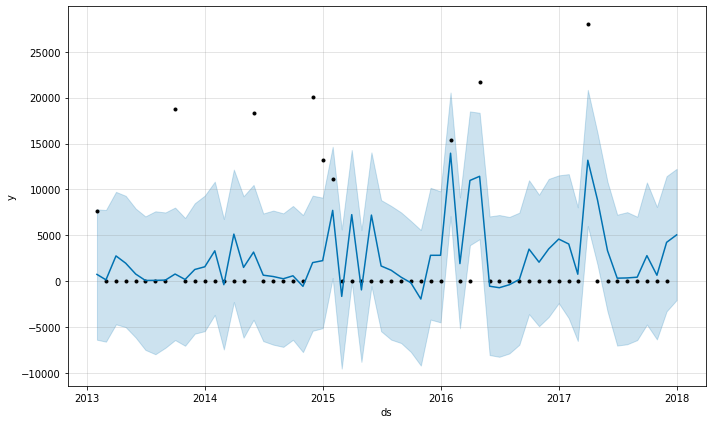

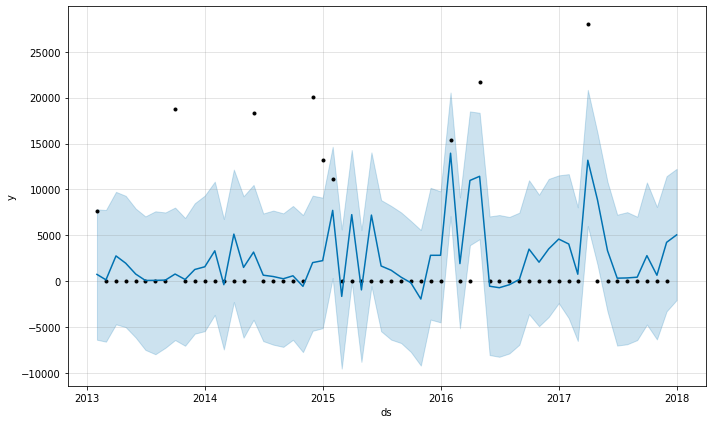

In [12]:
m.plot(forecast)

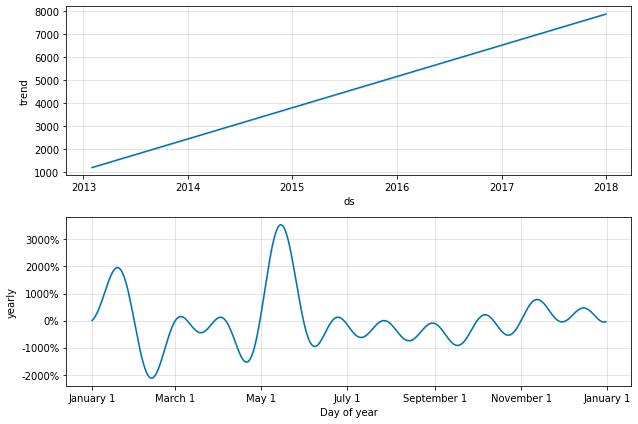

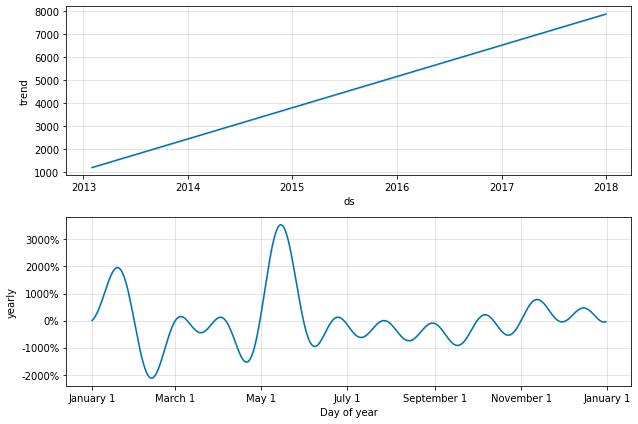

In [13]:
m.plot_components(forecast)

In [14]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [15]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df = cmp_df.dropna()

In [16]:
print('MAE:', metrics.mean_absolute_error(cmp_df.y[-prediction_size:],cmp_df.yhat[-prediction_size:]))  
print('MSE:', metrics.mean_squared_error(cmp_df.y[-prediction_size:],cmp_df.yhat[-prediction_size:]))
print('RMSE:', np.sqrt(metrics.mean_squared_error(cmp_df.y[-prediction_size:],cmp_df.yhat[-prediction_size:])))

MAE: 5024.2956661248145
MSE: 25243546.940640595
RMSE: 5024.2956661248145


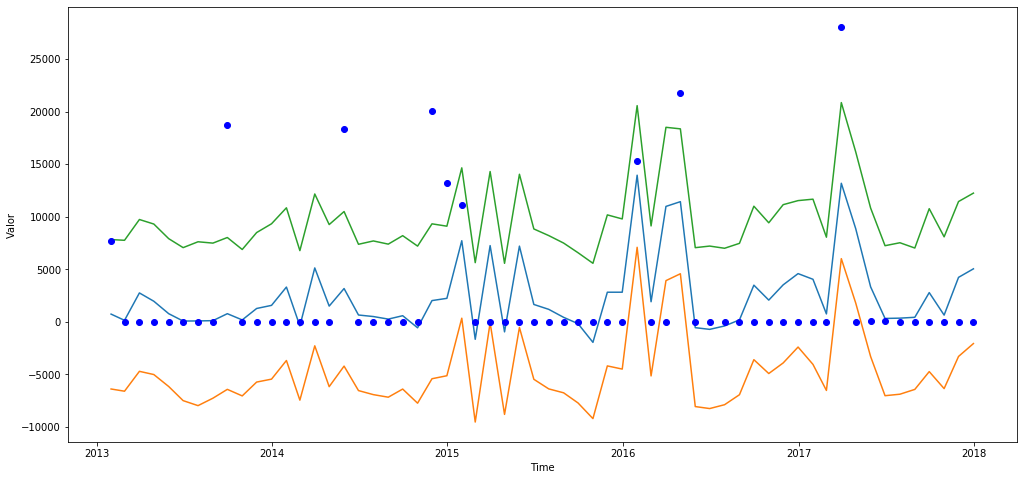

In [17]:
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'],'bo')
plt.xlabel('Time')
plt.ylabel('Valor')
plt.grid(False)
plt.show()